# **제1회 KRX 금융 빅데이터 활용 아이디어 경진대회 - 개념증명 PoC**

## **1. 팀 소개**

이름 : bada

구분 : 팀, 일반

소개 : 안녕하세요! 저희는 고려대학교 경영대학 소속 비즈니스애널리틱스 학회 bada에서 본 경진대회에 참가하게 된 팀입니다. 창의적인 방법으로 문제를 정의하고 솔루션을 제시하는 비즈니스 프로세스에 도전해보고 싶습니다.

## **2. 비즈니스 아이디어 개요**


<img src='https://drive.google.com/uc?export=download&id=1iWQbkXauw_Ik1BDXdWczyJqH-eUCtrtZ' width="50%" height ="" /><br>

### **실행환경**

**사용한 환경**
* Google Colab


**사용한 모듈**
* pandas, numpy, matplotlib
* sklearn, scipy
* (외부 모듈) pykrx

In [ ]:
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 1.4 MB/s 
     |████████████████████████████████| 52 kB 843 kB/s 
     |████████████████████████████████| 251 kB 54.3 MB/s 


## **3. 비정형데이터를 활용한 차트 발굴 모델**

### **3-1. 이미지 데이터로 차트 찾기**

"재미있는 이미지와 가장 유사한 차트를 찾아주는 분석"

#### **아이디어 개요**

<img src='https://drive.google.com/uc?export=download&id=1rwiv1F2y5k9j6eFr6GRztTn5Tfc09Akn' width="50%" height ="" /><br>

#### **실행방법**


**1. 아래 링크에서 test_image.png 다운로드.**

<img src='https://drive.google.com/uc?export=download&id=1OUyTPoJvAJoSBqKJEA-Aoa4hcuQFSGoZ' width="500" height ="" />

> https://drive.google.com/file/d/1OUyTPoJvAJoSBqKJEA-Aoa4hcuQFSGoZ/view

**2. 다운로드한  test_image.png를 Colab의 좌측 메뉴 중 파일에 드래그 앤 드롭.**

<!-- <img src='./1.png' width=800> -->
<img src='https://drive.google.com/uc?export=download&id=1gjKBucZZlP6wuDx39WyKV0_4Xbn2Oc8b' width="800" height ="" />

**3. 아래의 실행코드를 실행.**

#### **실행코드**

1. 입력된 이미지데이터 분석

2. 주가데이터 불러오기

3. 이미지데이터와 주가데이터 사이의 유사도 계산

4. 가장 유사한 주가데이터 및 이미지데이터를 시각화

Checked - 200
Tinker - 105630
Name - 한세실업
Similarity - 29
Probability - 0.9323


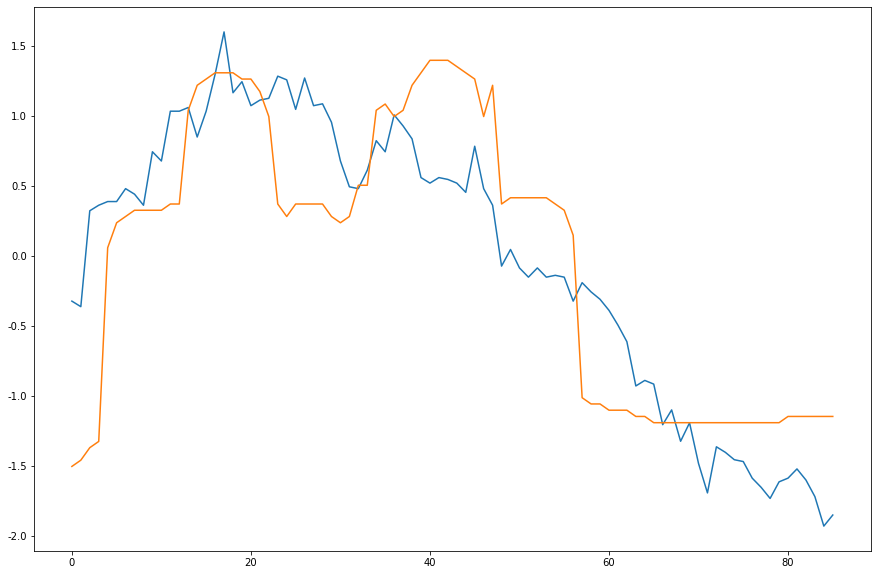

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
# 외부 패키지 및 모듈
from pykrx import stock
import cv2


### tinker에 해당하는 주가데이터를 불러오는 함수
def get_np_stockPrice(tinker):
  # pykrx　모듈로부터 특정 시기에 해당하는 주가데이터를 불러옴.
  df_target = stock.get_market_ohlcv_by_date('20220314', '20220714', tinker)
  np_stockPrice = df_target['시가'].to_numpy()
  np_stockPrice_reshaped = np_stockPrice.reshape(-1,1)
  # 주가데이터를 스케일링함.
  ss_stockPrice = StandardScaler()
  ss_stockPrice.fit(np_stockPrice_reshaped)
  np_stockPrice_scaled = ss_stockPrice.transform(np_stockPrice_reshaped)
  # 리턴값.
  return np_stockPrice_scaled


### 최상단 좌표점을 추출해서 리턴하는 함수
def remain_top_coordinate(image_canny):
  coordinate = []
  for num in range(image_canny.shape[1]):
    # 최상단 좌표일 경우를 저장할, bool 변수 선언함.
    isTop = False
    for i, e in enumerate(image_canny[:,num]):
      if e != 0:
        if isTop == False:
          isTop = True
          context = i
          coordinate.append(context)
        else:
          image_canny[i,num] = 0
  return coordinate


### 입력된 이미지의 윤곽선을 추출하는 함수
def get_np_imageOutline(image, np_stockPrice_scaled):
  # 이미지 width, height 비율을 고정함.
  width, height = image.shape
  size = len(np_stockPrice_scaled)
  height_sized = height / width
  image_gray_resized = cv2.resize(image, (size, size))
  # 주가 데이터 수에 맞춰 이미지 크기를 변환함.
  median_intensity = np.median(image_gray_resized)
  lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
  upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))
  image_canny = cv2.Canny(image_gray_resized, lower_threshold, upper_threshold)
  # {최상단 좌표점을 추출해서 리턴하는 함수}를 호출.
  coordinate = remain_top_coordinate(image_canny)
  # 이미지 좌표값을 numpy.array로 변환함.
  np_coordinate = np.array(coordinate)
  np_coordinate = (np_coordinate - max(np_coordinate)) * (-1)
  np_coordinate_reshaped = np_coordinate.reshape(-1,1)
  # 이미지의 좌표데이터를 스케일링함.
  ss_coordinate = StandardScaler()
  ss_coordinate.fit(np_coordinate_reshaped)
  np_coordinate_scaled = ss_coordinate.transform(np_coordinate_reshaped)
  # 리턴값
  return np_coordinate_scaled, height_sized


# 정규분포를 활용하여 유사도 지수를 계산하는 함수
def get_prob(np_input):
  np_input_zero = np.append(np_input, np.array([0]))
  m = np_input_zero.mean()
  s = np_input_zero.std()
  x1 = 0
  x2 = min(np_input)
  zstat1 = (x1-m)/s
  zstat2 = (x2-m)/s
  p = norm.cdf(zstat2) - norm.cdf(zstat1)
  p_inverted = 1 - p
  p_inverted_rounded = round(p_inverted, 4)
  return p_inverted_rounded


# 차트를 그리는 함수
def get_chart(tinker, image):
  np_stockPrice_scaled = get_np_stockPrice(tinker)
  np_coordinate_scaled, r = get_np_imageOutline(image_gray, np_stockPrice_scaled)
  height_resized = round(10 * r)
  plt.figure(figsize=(height_resized, 10))
  plt.plot(np_stockPrice_scaled)
  plt.plot(np_coordinate_scaled)
  plt.show()



# {tinker에 해당하는 주가데이터를 불러오는 함수}를 호출
li_tinker_KOSPI200 = stock.get_index_portfolio_deposit_file("1028")
# 이미지를 입력함.
inp_img = 'test_image.png'
# opencv로 이미지를 파싱함.
image_gray = cv2.imread(inp_img, cv2.IMREAD_GRAYSCALE)



num = 0
container = []
for e in li_tinker_KOSPI200:
  np_stockPrice_scaled = get_np_stockPrice(e)
  np_coordinate_scaled, r = get_np_imageOutline(image_gray, np_stockPrice_scaled)
  try:
    similarity = sum((np_coordinate_scaled - np_stockPrice_scaled)**2)
    # num = num + 1
  except:
    print(f'Error - {e}')
    continue
  similarity_rounded = np.round(similarity, 0)
  context = (e, similarity_rounded)
  container.append(context)
  # print(f'{num} done - {e}                 ', end='\r')



num_checked = len(container)
sims = [int(e[1]) for e in container]
sims_min = min(sims)
target_index = sims.index(sims_min)
target_tinker = container[target_index][0]
target_name = stock.get_market_ticker_name(target_tinker)
target_similarity = sims_min
np_sims = np.array(sims)


# {정규분포를 활용하여 유사도 지수를 계산하는 함수}를 호출함.
target_prob = get_prob(np_sims)


# 세부정보를 출력함.
print(f'Checked - {num_checked}')
print(f'Tinker - {target_tinker}')
print(f'Name - {target_name}')
print(f'Similarity - {target_similarity}')
print(f'Probability - {target_prob}')


# {차트를 그리는 함수}를 호출함.
get_chart(target_tinker, inp_img)

### **3-2. 차트데이터로 멜로디(오디오) 만들기**


"네가 원하는 종목의 차트를 음악으로 바꿔주는 분석"

#### **아이디어 개요**

<img src='https://drive.google.com/uc?export=download&id=1YGqviYJukbxyF2q2bO_sMhKYfFOn6TAz' width="50%" height ="" /><br>

#### **실행방법**

**1. 아래의 실행코드를 실행.**

#### **실행코드**

1. 주가데이터 불러오기

2. 군집화 알고리즘으로 주가데이터 나누기

3. 계이름 출력값 설정하기

4. 해당 시기 주가의 군집에 계이름 할당하기

5. 계이름을 모두 합쳐서 하나의 멜로디로 만들기


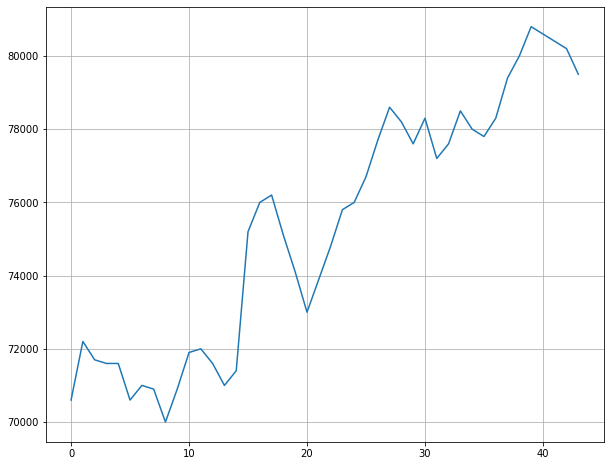

In [70]:
import librosa.display, librosa
import IPython.display
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pykrx import stock
# 경고 무시
warnings.simplefilter("ignore")


# 삼성전자 주가 불러오기.
ticker = '005930'
name = stock.get_market_ticker_name(ticker)
df_ohlcv = stock.get_market_ohlcv_by_date("20211101", "20211230", ticker)
df_stockPrice = df_ohlcv['고가']


# 데이터 전처리.
np_stockPrice = np.array(df_stockPrice)
np_stockPrice_reshaped = np_stockPrice.reshape(-1,1)


# k-means 군집화 알고리즘.
km = KMeans(n_clusters=7)
km.fit(np_stockPrice_reshaped)
clusters = km.predict(np_stockPrice_reshaped)


# 군집화 결과를 DataFrame 객체에 반영함.
context = {'stock_price': np_stockPrice, 'cluster':clusters}
df_stockPrice = pd.DataFrame(context)



# 음계 준비하는 함수
def sin_wave(amp, freq, time):
    return amp * np.sin(2*np.pi*freq*time)


# 샘플링레이트와 시간을 설정
sr = 22*1000.
ts = 1/sr
time = np.arange(0, 1, ts)


# 도레미파솔라시 7음계를 정의함.
DO = sin_wave(1, 261.6256, time)
RE = sin_wave(1, 294, time)
MI = sin_wave(1, 329.6276, time)
FA = sin_wave(1, 349, time)
SOL = sin_wave(1, 391.9954, time)
LA = sin_wave(1, 440, time)
SI = sin_wave(1, 494, time)
syllable_name = (DO, RE, MI, FA, SOL, LA, SI)


# 각 cluster에 계이름을 할당함.
sorted_cluster_centers = sorted(km.cluster_centers_)
syllable = []
for i,e in enumerate(km.cluster_centers_):
  target_index = sorted_cluster_centers.index(e)
  syllable.append(syllable_name[target_index])
container = []
for i in df_stockPrice.iterrows():
  # print(i[1]['cluster'])
  target_index = i[1]['cluster']
  container.append(syllable[target_index])


# 차트를 출력함.
plt.figure(figsize=(10,8))
plt.plot(np_stockPrice)
plt.grid()
plt.show()


# 멜로디를 출력하는 위젯.
sample_concat = np.concatenate(container)
IPython.display.Audio(data=sample_concat, rate=sr*2)

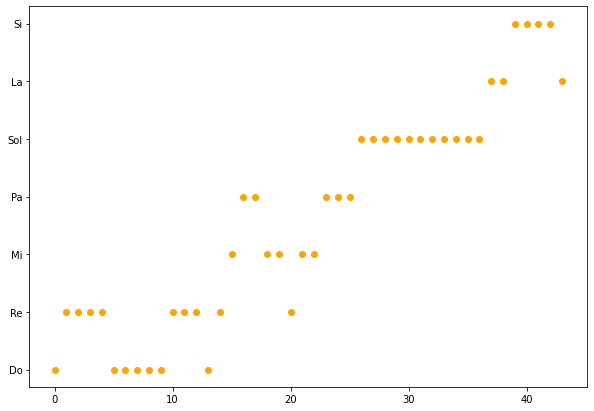

In [71]:
# 군집화 결과를 음의 높낮이로 시각화

sorted_cluster_centers = sorted(km.cluster_centers_)
con = []
for i,e in enumerate(km.cluster_centers_):
  for j, s in enumerate(sorted_cluster_centers):
    if e == s:
      con.append(j)
con2 = []
for r in df_stockPrice.iterrows():
  target = r[1][1]
  con2.append(con[target])
df_stockPrice['syllabus'] = con2
plt.figure(figsize=(10,7))
plt.scatter(df_stockPrice.index, df_stockPrice['syllabus'], c='orange')
plt.yticks(np.arange(0,7), labels=['Do', 'Re', 'Mi', 'Pa', 'Sol', 'La', 'Si'])
plt.show()